In [1]:
import numpy as np
from scipy.optimize import minimize
import cvxpy as cp  
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics.pairwise import linear_kernel
from sklearn.gaussian_process.kernels import DotProduct
np.random.seed(0)

In [2]:
def sqexp(v, v_prime, z, z_prime, tau, L):
   
    # Square Exponential Kernel
    cov = tau * np.exp(-1/2 * (v - v_prime)**2 / L**2)* tau * np.exp(-1/2 * (z - z_prime)**2 / L**2)
    return cov

In [3]:
def affineDotProductKernel(v, v_prime, z, z_prime, u, u_prime, tau_1, L_1, tau_2, L_2):  ## accept tau , l1, tau2, l2
    #Affine Dot Product Compound Kernel
    
    # Using the square exponential kernel for the two kernels necessary 
    kern1 = sqexp(v, v_prime, z, z_prime, tau_1, L_1)
    kern2 = sqexp(v, v_prime, z, z_prime, tau_2, L_2)   ## Change Tau and L values for each kernel 1 and 2 

    # Stacking required number kernels 
    # here m = 1 since u is one value, therefore m+1 = 2 kernels required
    kernels = np.array([kern1, kern2])

    # Constructing diagonal matric of kernels 
    diagonal_Matrix = np.diag(kernels)

    # Constructing the affine dot product compound kernel
    y = np.array([1, u]).reshape(-1,1)
    y_prime = np.array([1, u_prime]).reshape(-1, 1)
    affine_dot_product_kernel = np.dot(y.T, np.dot(diagonal_Matrix, y_prime))   ## has to be y = [1, u] and y' = [1, u'] find out how the control inputs are different for (v,z) and (v', z')

    return affine_dot_product_kernel

In [4]:
def build_covariance(x, xp, y, yp, func, u_input, u_input_prime, tau_1, L_1, tau_2, L_2): ## take tau1, L1, amd tau2, L2
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    kern = func
    out = np.zeros((x.shape[0], xp.shape[0]))
    for ii in range(x.shape[0]):
        for jj in range(xp.shape[0]):
            out[ii, jj] = kern(x[ii], xp[jj], y[ii], yp[jj], u_input[ii], u_input_prime[jj], tau_1, L_1, tau_2, L_2)
    return out

In [5]:
# True Plant   
def TruePlant(X):
    """
    State X = [v,z]
    v -> forward velcity of ego car
    z -> distance between ego car and front car
    
    """
    f0_true = 0.2
    f1_true = 10
    f2_true = 0.5
    m_true = 3300
    v0 = 14   # m/s
    f_r = f0_true + f1_true*X[0] + f2_true*X[0]**2
    f_X = np.array([(-f_r/m_true), v0 - X[0]]). reshape(-1,1)
    g_X = m_true * np.array([1/m_true, 0]).reshape(-1,1)

    return f_X, g_X


In [6]:
# Nominal Plant
def NominalPlant(X):
    """
    State X = [v,z]
    v -> forward velcity of ego car
    z -> distance between ego car and front car
    
    """
    f0_nom = 0.1
    f1_nom = 5
    f2_nom = 0.25
    m_nom = 1650    
    m_true = 3300
    v0 = 14    # m/s
    f_r = f0_nom + f1_nom*X[0] + f2_nom*X[0]**2
    f_X = np.array([(-f_r/m_nom), v0 - X[0]]). reshape(-1,1)
    g_X = m_true * np.array([1/m_nom, 0]).reshape(-1,1)

    return f_X, g_X


In [7]:
# Function to find LfV + LgV*u (Lyapunov output) for true dynamics (or nominal dynamics???) used for training GP 

def output_V_X(X, u):

    vd = 24  # desired speed command in m/s
    dV_dx = np.array([2*(X[0] - vd), 0]).reshape(1,-1)

    x0_T, x1_T = TruePlant(X)
    x0_N, x1_N = NominalPlant(X) 
    f_X = x0_T - x0_N
    g_X = x1_T - x1_N

    true_out_V = dV_dx @ f_X + dV_dx @ g_X * u

    return true_out_V
    


In [8]:
# Function to find LfH + LgH*u (Barrier output) for true dynamics (or nominal dynamics???) used for training GP 

def output_H_X(X, u):

    Th = 1.8   # Lookahead time in sec
    dH_dx = np.array([-Th, 1]).reshape(1,-1)

    x0_T, x1_T = TruePlant(X)
    x0_N, x1_N = NominalPlant(X) 
    f_X = x0_T - x0_N
    g_X = x1_T - x1_N

    true_out_H = dH_dx @ f_X + dH_dx @ g_X * u

    return true_out_H

In [9]:
np.random.seed(0)
n_total_pts = 100
n_train_pts = 50
v_max = 50
z_max = 100
u_train_test = np.random.uniform(low = -5, high = 5, size = n_total_pts)
v_train_test = np.random.uniform(low = 0, high = v_max, size = n_total_pts)
z_train_test = np.random.uniform(low = 0, high = z_max, size = n_total_pts)

utrain = u_train_test[0:n_train_pts]
utest = u_train_test[n_train_pts:n_total_pts]

vtrain = v_train_test[0:n_train_pts]
vtest = v_train_test[n_train_pts:n_total_pts]

ztrain = z_train_test[0:n_train_pts]
ztest = z_train_test[n_train_pts:n_total_pts]

state_X_train = np.vstack((vtrain, ztrain))
state_X_test = np.vstack((vtest, ztest))

###### Generate Training data outputs for training GP
out_Vx_train = np.zeros((state_X_train[0].shape))
for ii in range(len(state_X_train[0])):
    out_Vx_train[ii] = output_V_X(state_X_train[:,ii], utrain[ii]).squeeze()

out_Hx_train = np.zeros((state_X_train[0].shape))
for ii in range(len(state_X_train[0])):
    out_Hx_train[ii] = output_H_X(state_X_train[:,ii], utrain[ii]).squeeze()


####### Generate true values to compare with GP output
out_Vx_truth = np.zeros((state_X_test[0].shape))
for ii in range(len(state_X_test[0])):
    out_Vx_truth[ii] = output_V_X(state_X_test[:,ii], utest[ii]).squeeze()

out_Hx_truth = np.zeros((state_X_test[0].shape))
for ii in range(len(state_X_test[0])):
    out_Hx_truth[ii] = output_H_X(state_X_test[:,ii], utest[ii]).squeeze()
print(out_Vx_truth)



[  23.20366147   23.83035251  155.0621441    53.94663206 -103.69228201
  124.64088461  -50.11525766   21.98190044   -2.45313844 -104.99840192
   74.14982503  -10.30842853  -37.84045249  139.79971282  150.34996478
   49.33351964  150.31660861  -48.3566847   -84.48303749 -124.55126431
  -19.55227944  -13.34399257  133.49476149   48.38392231  -75.05643535
 -118.00262984  -29.24467745  170.18281611   45.74907565 -170.87139361
  -57.39096715   12.12993449   42.37732377   46.59888178  -30.25131278
   31.42982113   -1.29335438   44.62998886  -18.9958916    72.14537442
  -14.83723835   45.22696063 -108.18036328 -100.4563808    54.65981601
    3.31344091   21.85190182 -108.28462165  138.80310033  -22.57765157]


In [10]:
def max_marg_likelihood(des_var, *args):   ### optimize for tau1, L1, tau2, L2
    inp = args[0]
    tau1, L1, tau2, L2, sigma = des_var
    
    cov = build_covariance(vtrain, vtrain, ztrain, ztrain, affineDotProductKernel, utrain, utrain, tau1, L1, tau2, L2)
    #print("cov from marg like = ", cov)
    n_init = len(state_X_train[0])
    mean_func = np.mean(inp)*np.ones((n_init,1))

    subterm_1 = (inp.reshape(-1,1) - mean_func).T
    subterm_2 = np.linalg.inv(cov + (sigma**2)*np.identity(vtrain.shape[0]))
    subterm_3 = subterm_1.T
    
    term1 = np.dot(subterm_1,np.dot(subterm_2,subterm_3))
    term2 = np.log(np.linalg.det((cov + (sigma**2)*np.identity(vtrain.shape[0]))))
    #print(term2)
    term3 = (n_init)*np.log(2*np.pi)
    
    mx_marg_lh = (1/2)*(term1 + term2 + term3)
    
    return mx_marg_lh
    

In [11]:
const = ((0,None),(0,None),(0,None),(0,None),(0,None))
#results = minimize(max_marg_likelihood,(5, 2, 4, 6, 2), bounds = const,args=(out_Vx_train,))
#results = minimize(max_marg_likelihood,(2, 10, 3, 9, 0.1), bounds = const,args=(out_Vx_train,))
results = minimize(max_marg_likelihood,(35, 28, 36, 26, 0.1), bounds = const,args=(out_Vx_train,))

tau_1_V, L_1_V, tau_2_V, L_2_V, sigma_V = results.x
print(results)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 93.58342512584005
        x: [ 3.131e+01  3.689e+01  3.302e+01  4.023e+01  0.000e+00]
      nit: 4
      jac: [ 7.627e+00  9.084e+00  8.028e+00  4.714e+00  0.000e+00]
     nfev: 156
     njev: 26
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


[ 1.089e+01  2.512e+01  5.469e+00  1.004e+01  0.000e+00]

35, 28, 36, 26, 0.1 

In [12]:
const = ((0,None),(0,None),(0,None),(0,None),(0,None))

#results = minimize(max_marg_likelihood,(5, 5, 4, 5, 0.1), bounds = const, args=(out_Hx_train,))
#results = minimize(max_marg_likelihood,(11, 10, 12, 9, 0.1), bounds = const, args=(out_Hx_train,))

#results = minimize(max_marg_likelihood,(7, 9, 5, 8, 0.1), bounds = const, args=(out_Hx_train,))  ## converged
#results = minimize(max_marg_likelihood,(3.764e+03, 1.106e+04, 0.000e+00, 2.928e+03, 0.000e+00), bounds = const, args=(out_Hx_train,))

results = minimize(max_marg_likelihood,(35, 28, 36, 26, 0.1), bounds = const, args=(out_Hx_train,))   ## converged 

tau_1_H, L_1_H, tau_2_H, L_2_H, sigma_H = results.x
print(results)

C:\Users\ivaishi\AppData\Local\Temp\ipykernel_22988\1194295822.py:15: RuntimeWarning: divide by zero encountered in log
  term2 = np.log(np.linalg.det((cov + (sigma**2)*np.identity(vtrain.shape[0]))))
c:\Users\ivaishi\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 75.24052233119048
        x: [ 3.142e+01  3.731e+01  3.157e+01  4.046e+01  0.000e+00]
      nit: 5
      jac: [-1.114e+01  9.461e+00 -7.918e+00  1.063e+01  0.000e+00]
     nfev: 168
     njev: 28
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


1. [ 5.235e+01  1.599e+02  9.926e-02  3.921e+01  0.000e+00]  (Converged, fun value = 15.401)
2. [ 1.594e+02  5.533e+02  0.000e+00  1.585e+02  0.000e+00]  (Did not converge)
3. [ 3.764e+03  1.106e+04  0.000e+00  2.928e+03  0.000e+00]  (Converged, fun value = 73.925) ## works best
4. [ 6.534e+01  1.505e+02  0.000e+00  3.976e+01  0.000e+00]  (did not converge)
5. [ 3.782e+01  1.086e+02  2.674e-01  5.840e+01  0.000e+00]  (did not converge)

In [13]:
### only for testing GP with randomly generated control inputs for testing 

def gpr_affine(xinit, yinit, controller_init, controller_test, xpred, ypred, output_values, noise_var, ADP_kernel, tau_1, L_1, tau_2, L_2):  ### Return b* and C* from this function instead of mean and covariance
    """Gaussian process regression Algorithm

    Inputs
    -------
    xinit: (N, ) training inputs
    yinit: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    ypred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    ADP_kernel: Affine Dot Product Compound Kernel 
    SQE_kernel: Square Exponential Kernel 
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    # constructing covariance matrix (Gram Matrix Kc) from training datapoints
    Kc = build_covariance(xinit, xinit, yinit, yinit, ADP_kernel, controller_init, controller_init, tau_1, L_1, tau_2, L_2) 
    # print("Kc = ", Kc)
    
    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(Kc + np.diag(noise_var))

    # constructing covariance matrix (Gram Matrix Ky*) from training datapoints and query point
    Y_o = np.vstack((np.ones(xinit.shape), controller_init))
    K_1star = sqexp(xpred, xinit, ypred, yinit, tau_1, L_1)
    K_2star = sqexp(xpred, xinit, ypred, yinit, tau_2, L_2)
    # print(Ky_1star.T[0], yinit[0], Ky_1star*yinit)
    K_istar = np.vstack((K_1star.T, K_2star.T))
    Ky_star = np.multiply(K_istar, Y_o)
    #print("Ky_star = ", Ky_star)

    # Controller input 
    y_star = np.array([1, controller_test]).reshape(-1,1)

    # Calculating predicted mean (scalar value)
    pred_mean = np.dot(np.dot(output_values.T, np.dot(invcov, Ky_star.T)), y_star)

    # Calculating predicted mean (scalar value)
    pred_mean_coefficient = np.dot(output_values.T, np.dot(invcov, Ky_star.T))

    
    # Contructing diagonal of covariance matrix for query point using both kernels
    Kss_1 = sqexp(xpred, xpred, ypred, ypred, tau_1, L_1)
    # print(Kss_1)
    Kss_2 = sqexp(xpred, xpred, ypred, ypred, tau_2, L_2)
    # print(Kss_2)
    Kss = np.hstack((Kss_1.T, Kss_2.T)).reshape(1,-1)
    #print("Kss = ", Kss.shape)
    diag_mat = np.diag([Kss_1, Kss_2])
    #print("Diag_Kss = ", diag_mat)

    # Calculating predicted covariance (scalar value)
    pred_cov = np.dot(y_star.T, np.dot(np.subtract(diag_mat, np.dot(Ky_star, np.dot(invcov, Ky_star.T))), y_star))

    # Calculating predicted covariance (scalar value)
    pred_cov_coefficient = np.subtract(diag_mat, np.dot(Ky_star, np.dot(invcov, Ky_star.T)))

    return pred_mean, pred_cov

mean =  [  23.34534053   24.12885676  154.90843819   53.8011061  -103.1017996
  124.58971801  -50.11270244   22.00783944   -2.63590776 -103.71187791
   74.15938792  -10.26165919  -38.04089767  138.76078298  150.51521418
   49.38297245  148.00606083  -48.17392995  -84.68765155 -124.37054735
  -19.35667335  -13.71878887  133.39796744   46.33449176  -75.08669732
 -117.44094186  -29.42216259  169.87765043   45.74367988 -169.09140911
  -56.98143664   12.01508464   42.38549375   46.27633509  -30.18156242
   31.43031677   -1.40518998   44.62899398  -18.99198861   72.08707484
  -14.74814286   45.09066412 -108.3791102  -100.42447844   54.69064257
    3.33854439   21.73517742 -108.48530371  134.44821597  -22.95287418]
cov =  [1.26097556e-01 1.04286276e-01 2.90375376e-01 1.00155801e-02
 8.91546981e+00 3.08341168e-03 3.28180647e-04 2.10831348e-03
 1.25677272e+00 3.55117208e+00 3.48303395e-04 5.46292246e-02
 1.72118553e-01 1.17617483e+00 3.61151566e-01 1.22781633e-02
 1.39417504e+00 6.21126444e-02 

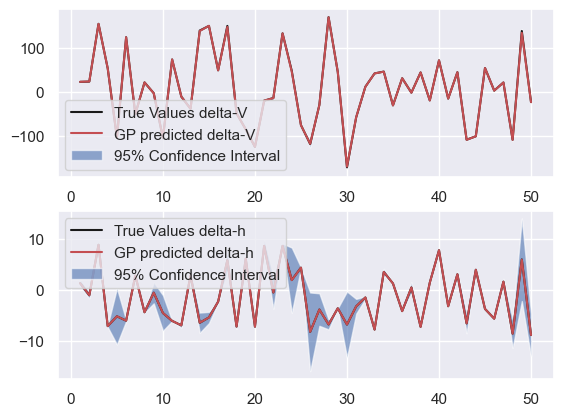

In [51]:
sigma_noise_V = sigma_V * np.ones((state_X_train.shape[1]))
mu_Vx = np.zeros((state_X_test.shape[1]))
cov_Vx = np.zeros((state_X_test.shape[1]))

for jj in range(len(mu_Vx)):
    mu_Vx[jj], cov_Vx[jj] = gpr_affine(vtrain, ztrain, utrain, utest[jj], vtest[jj], ztest[jj], out_Vx_train, sigma_noise_V, affineDotProductKernel, tau_1_V, L_1_V, tau_2_V, L_2_V)

std_Vx = np.sqrt(np.abs(cov_Vx))
print("mean = ", mu_Vx)
print("cov = ", cov_Vx)
print("standard deviation = ", std_Vx)

fig, ax = plt.subplots(2,1)
x = np.linspace(1, len(out_Vx_truth), len(out_Vx_truth))
ax[0].plot(x, out_Vx_truth, 'k', label = "True Values delta-V")

x_test_V = np.linspace(1, len(mu_Vx), len(mu_Vx))
ax[0].plot(x_test_V, mu_Vx, 'r', label = "GP predicted delta-V")
lower_V = mu_Vx - 1.96*std_Vx
upper_V = mu_Vx + 1.96*std_Vx
ax[0].fill_between(x_test_V, lower_V, upper_V, alpha=0.6, label = '95% Confidence Interval')
ax[0].legend()

sigma_noise_H = sigma_H * np.ones((state_X_train.shape[1]))
mu_Hx = np.zeros((state_X_test.shape[1]))
cov_Hx = np.zeros((state_X_test.shape[1]))

for jj in range(len(mu_Hx)):
    mu_Hx[jj], cov_Hx[jj] = gpr_affine(vtrain, ztrain, utrain, utest[jj], vtest[jj], ztest[jj], out_Hx_train, sigma_noise_H, affineDotProductKernel, tau_1_H, L_1_H, tau_2_H, L_2_H)

std_Hx = np.sqrt(np.abs(cov_Hx))
print("mean = ", mu_Hx)
print("cov = ", cov_Hx)
print("standard deviation = ", std_Hx)

x = np.linspace(1, len(out_Hx_truth), len(out_Hx_truth))
ax[1].plot(x, out_Hx_truth, 'k', label = "True Values delta-h")

x_test_h = np.linspace(1, len(mu_Hx), len(mu_Hx))
ax[1].plot(x_test_h, mu_Hx, 'r', label = "GP predicted delta-h")
lower_h = mu_Hx - 1.96*std_Hx
upper_h = mu_Hx + 1.96*std_Hx
ax[1].fill_between(x_test_h, lower_h, upper_h, alpha=0.6, label = '95% Confidence Interval' )
ax[1].legend()
plt.show()



In [52]:
### only for testing GP with randomly generated control inputs for testing 

def gpr_for_controller(xinit, yinit, controller_init, xpred, ypred, output_values, noise_var, ADP_kernel, tau_1, L_1, tau_2, L_2):  ### Return b* and C* from this function instead of mean and covariance
    """Gaussian process regression Algorithm

    Inputs
    -------
    xinit: (N, ) training inputs
    yinit: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    ypred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    ADP_kernel: Affine Dot Product Compound Kernel 
    SQE_kernel: Square Exponential Kernel 
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    # constructing covariance matrix (Gram Matrix Kc) from training datapoints
    Kc = build_covariance(xinit, xinit, yinit, yinit, ADP_kernel, controller_init, controller_init, tau_1, L_1, tau_2, L_2) 
    
    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(Kc + np.diag(noise_var))

    # constructing covariance matrix (Gram Matrix Ky*) from training datapoints and query point
    Y_o = np.vstack((np.ones(xinit.shape), controller_init))
    K_1star = sqexp(xpred, xinit, ypred, yinit, tau_1, L_1)
    K_2star = sqexp(xpred, xinit, ypred, yinit, tau_2, L_2)
    # print(Ky_1star.T[0], yinit[0], Ky_1star*yinit)
    K_istar = np.vstack((K_1star.T, K_2star.T))
    Ky_star = np.multiply(K_istar, Y_o)
    #print("Ky_star = ", Ky_star)

    # Calculating predicted mean (scalar value)
    pred_mean_coefficient = np.dot(output_values.T, np.dot(invcov, Ky_star.T))

    
    # Contructing diagonal of covariance matrix for query point using both kernels
    Kss_1 = sqexp(xpred, xpred, ypred, ypred, tau_1, L_1)
    Kss_2 = sqexp(xpred, xpred, ypred, ypred, tau_2, L_2)
    diag_mat = np.diag([Kss_1, Kss_2])

    # Calculating predicted covariance (scalar value)
    pred_cov_coefficient = np.subtract(diag_mat, np.dot(Ky_star, np.dot(invcov, Ky_star.T)))

    return pred_mean_coefficient, pred_cov_coefficient

In [53]:
# GP-CBF-CLF-SOCP
u = cp.Variable()
delta = cp.Variable()

lfh_nom = cp.Parameter()
lgh_nom = cp.Parameter()
lfV_nom = cp.Parameter()
lgV_nom = cp.Parameter()

h = cp.Parameter()
V = cp.Parameter()

Q_V = cp.Parameter((2,1))
r_V = cp.Parameter((2,1))
w_V = cp.Parameter()
v_V = cp.Parameter()
#G_V = cp.Parameter((2,2))

Q_h = cp.Parameter((2,1))
r_h = cp.Parameter((2,1))
w_h = cp.Parameter()
v_h = cp.Parameter()


alpha = 75
k = 1.0
v0 = 14     # m/s
vd = 24     # m/s
t_h = 1.8   # sec
beta = 2    # confidence interval

# const = [delta - w_V*u - v_V -k*V >= Q_V*u + r_V]
#const = [cp.SOC(w_h * u + v_h + alpha * h, Q_h * u + r_h)]
# const = [ lfh_nom + (lgh_nom * u) + mu_h_f + mu_h_g * u >= -alpha * h]
const = [ v_V + w_V * u <= -k * V + delta]
const += [ v_h + w_h * u >= -alpha * h]
objective = cp.Minimize(0.01*u**2 + 1000*delta**2)
problem = cp.Problem(objective, const)

class AdaptiveCruiseControl:
    
    def __init__(self, x0, dt):
        self.X = x0
        self.dt = dt
        
    def f_Nom(self):
        f_X,_ = NominalPlant(self.X)
        return f_X
    
    def f_true(self):
        f_X,_ = TruePlant(self.X)
        return f_X
        
    def g_Nom(self):
        _,g_X = NominalPlant(self.X)
        return g_X
    
    def g_true(self):
        _,g_X = TruePlant(self.X)
        return g_X
        
    def barrier(self):
        d_min = t_h * self.X[0,0]
        hx = self.X[1,0] - d_min
        dhx_dx = np.array([-t_h, 1]).reshape(1,-1)
        return hx, dhx_dx

    def lyapunov(self):
        V_val = (self.X[0,0] - vd)**2
        dV_dx = np.array([2*(self.X[0,0] - vd), 0]).reshape(1,-1)
        return V_val, dV_dx

    # use true dynamics            
    def step(self, U):
        self.X = self.X + ( self.f_true() + self.g_true() * U )*self.dt
        return self.X

In [59]:
initial_state = np.array([20, 100]).reshape(-1,1)
dt  = 0.0015
X_state = np.zeros((2,4000))
AdaptCruiseCont = AdaptiveCruiseControl(initial_state, dt)

for i in range(4000):
    
    h.value, dh_dx = AdaptCruiseCont.barrier()
    V.value, dV_dx = AdaptCruiseCont.lyapunov()
    test_1 = AdaptCruiseCont.f_Nom()
    print()
    
    lfh_nom.value = (dh_dx @ AdaptCruiseCont.f_Nom())[0][0]
    lgh_nom.value = (dh_dx @ AdaptCruiseCont.g_Nom())[0][0]
    lfV_nom.value = (dV_dx @ AdaptCruiseCont.f_Nom())[0][0]
    lgV_nom.value = (dV_dx @ AdaptCruiseCont.g_Nom())[0][0]

    b_Vx, C_Vx = gpr_for_controller(vtrain, ztrain, utrain, AdaptCruiseCont.X[0], AdaptCruiseCont.X[1], out_Vx_train, sigma_noise_V, affineDotProductKernel, tau_1_V, L_1_V, tau_2_V, L_2_V)
    b_hx, C_hx = gpr_for_controller(vtrain, ztrain, utrain, AdaptCruiseCont.X[0], AdaptCruiseCont.X[1], out_Hx_train, sigma_noise_H, affineDotProductKernel, tau_1_H, L_1_H, tau_2_H, L_2_H)
    
    G_hx = np.sqrt(np.abs(C_hx))    ## Construct Gram Matrix of C*
    G_Vx = np.sqrt(np.abs(C_Vx)) 

    Q_V.value = (beta * G_Vx[:, 1]).reshape(-1,1) #G2:m+1
    r_V.value = (beta * G_Vx[:, 0]).reshape(-1,1) #G1
    w_V.value = lgV_nom.value + b_Vx[1]
    v_V.value = lfV_nom.value + b_Vx[0]

    Q_h.value = beta * G_hx[:, 1].reshape(-1,1) #G2:m+1
    r_h.value = beta * G_hx[:, 0].reshape(-1,1) #G1
    w_h.value = lgV_nom.value + b_hx[1]
    v_h.value = lfV_nom.value + b_hx[0]

    problem.solve()
    if problem.status != 'optimal':
        print("QP not solvable")

    X_state[:,i] = AdaptCruiseCont.step(u.value).squeeze()
    #print("v = ", X_state[0,i], "z = ", X_state[1, i])

In [60]:
print(X_state[0])
print(X_state[1])

[20.00297805 20.00595385 20.0089274  ... 23.91511043 23.91539332
 23.91567666]
[99.991      99.98199553 99.9729866  ... 47.51541403 47.50054136
 47.48566827]


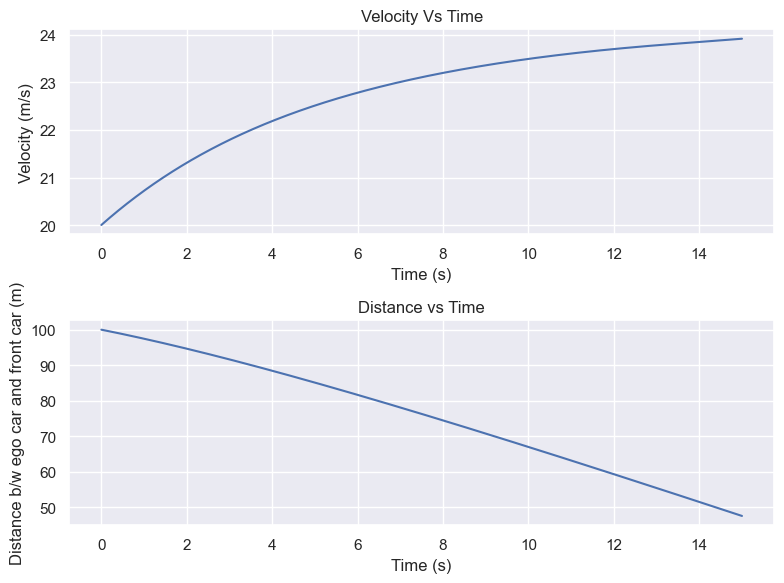

In [61]:
t = np.linspace(0, 15, 4000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot for X_state[0]
ax1.plot(t, X_state[0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Velocity Vs Time')

# Plot for X_state[1]
ax2.plot(t, X_state[1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance b/w ego car and front car (m)')
ax2.set_title('Distance vs Time')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
